In [229]:
# Import libraries

# ————— Standard library —————
import os
import re
import logging
import warnings
from datetime import datetime
from typing import List

# ————— Warnings —————
warnings.filterwarnings("ignore")

# ————— Data handling —————
import pandas as pd
import numpy as np
from numpy.linalg import inv


# ————— Plotting —————
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# ————— Database —————
import sqlite3
from sqlalchemy import create_engine

# ————— Linear algebra —————
from numpy.linalg import inv

# ————— scikit-learn —————
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    recall_score,
    classification_report,
    roc_curve,
    RocCurveDisplay,
    confusion_matrix,
    auc,
)

from sklearn.model_selection import StratifiedKFold, cross_val_score
import statsmodels.api as sm



# Load and Inspect the Assignments Dataset

In this cell we will:

1. **Read the raw CSV** without date parsing so we can inspect all column names.  
2. **Automatically detect** which column contains dates (by looking for “date” in its name).  
3. **Parse** that column into a proper `datetime` type and rename it to `due_date`.  
4. **Derive key temporal features** (`Year`, `Month`, `MonthName`, `DayOfWeek`) for later analysis.  
5. **Display** the first few rows and full column list to verify successful loading.  
6. **Compute basic EDA summaries**:
   - Count of assignments by month  
   - Count of assignments by day of week  


In [3]:
# 1) Load dataset
df = pd.read_csv('HADM1740_All_Major_Assignments.csv')

# 2) Detect date column
date_cols = [c for c in df.columns if 'date' in c.lower()]
if not date_cols:
    raise ValueError("No 'date' column found.")
date_col = date_cols[0]

# 3) Parse and rename
df[date_col] = pd.to_datetime(df[date_col])
df.rename(columns={date_col: 'due_date'}, inplace=True)

# 4) Derive temporal features
df['Year']      = df['due_date'].dt.year
df['Month']     = df['due_date'].dt.month
df['MonthName'] = df['due_date'].dt.month_name()
df['DayOfWeek'] = df['due_date'].dt.day_name()

# 5) Display head and columns
print(df.head())
print("Columns:", df.columns.tolist())

# 6) Compute summary counts
month_counts   = df['MonthName'].value_counts().sort_index()
dow_order      = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dow_counts     = df['DayOfWeek'].value_counts().reindex(dow_order, fill_value=0)
section_counts = df.get('Section', pd.Series()).value_counts()

print("Assignments by Month:\n", month_counts)
print("Assignments by Day of Week:\n", dow_counts)
print("Assignments by Section:\n", section_counts)

   StudentKey  Student # Section  \
0           1          1    FA23   
1           2          2    FA23   
2           3          3    FA23   
3           4          4    FA23   
4           5          5    FA23   

   Intro to Course and Syllabus Quiz (out of 100)   due_date  \
0                                           100.0 2023-08-21   
1                                            94.1 2023-08-21   
2                                            94.1 2023-08-21   
3                                           100.0 2023-08-21   
4                                            94.1 2023-08-21   

   Intro Assignment (out of 100) Intro Assignment Due Date  \
0                            100   Monday, August 21, 2023   
1                            100   Monday, August 21, 2023   
2                            100   Monday, August 21, 2023   
3                            100   Monday, August 21, 2023   
4                            100   Monday, August 21, 2023   

   Master Word Template (

# Plot Only Bar Charts & Histograms

From our long-form table, we’ll generate only bar charts and histograms:
1. **Score distribution** (histogram)
2. **Assignments due by day of week** (bar chart)
3. **Average score by assignment** (horizontal bar chart)


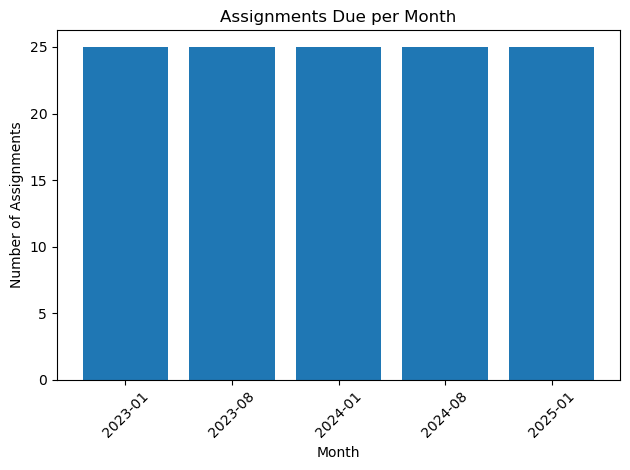

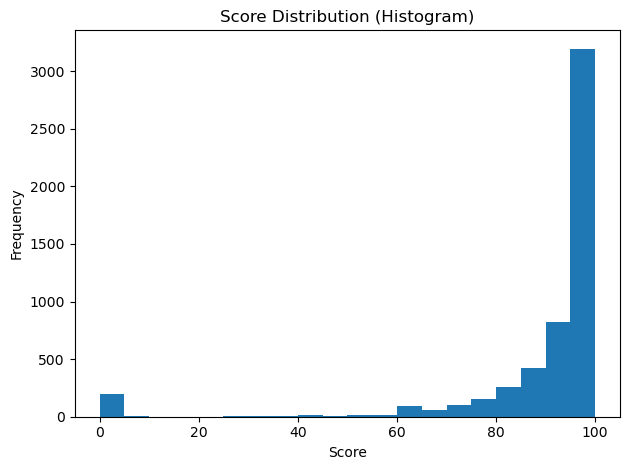

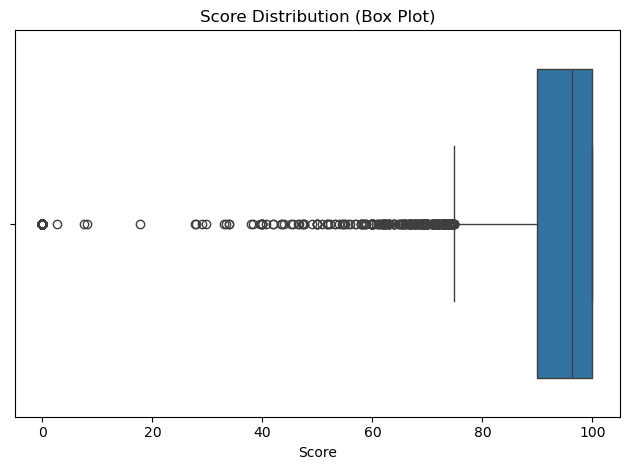

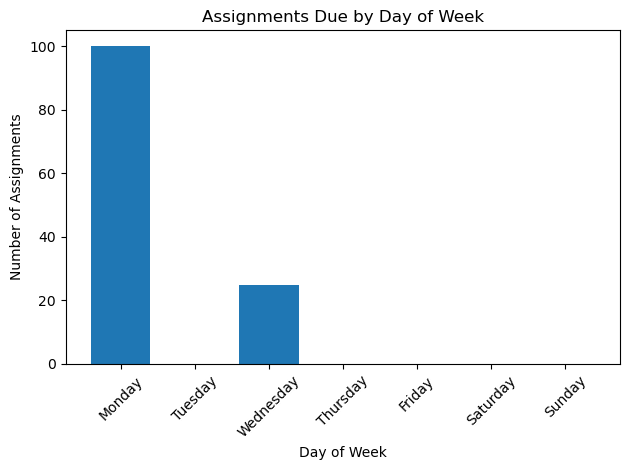

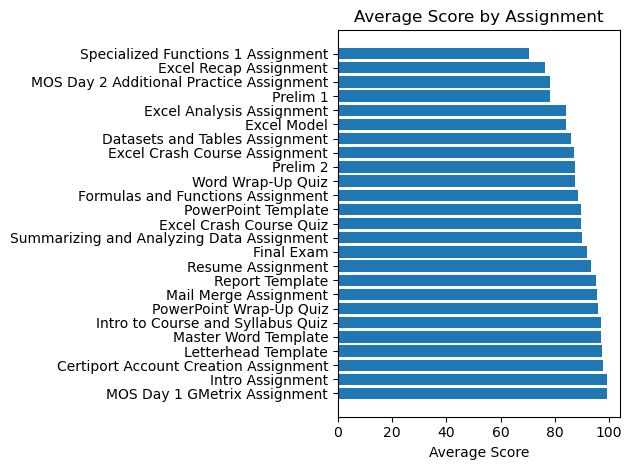

In [7]:
# — Prepare long_df —  
score_cols = [c for c in df.columns if '(out of' in c.lower()]  
id_vars    = ['StudentKey', 'Student #', 'Section', 'due_date']  

# Melt wide -> long  
long_df = df[id_vars + score_cols].melt(  
    id_vars=id_vars,  
    value_vars=score_cols,  
    var_name='Assignment',  
    value_name='Score'  
)  

# Clean assignment names  
long_df['Assignment'] = (  
    long_df['Assignment']  
      .str.replace(r"\s*\(out of.*\)", "", regex=True)  
      .str.strip()  
)  

# Cast to numeric, drop NaNs, keep only 0–100  
long_df['Score'] = pd.to_numeric(long_df['Score'], errors='coerce')  
long_df = long_df.dropna(subset=['Score', 'due_date'])  
long_df = long_df[(long_df['Score'] >= 0) & (long_df['Score'] <= 100)]  

# Standardize DueDate  
long_df['DueDate'] = pd.to_datetime(long_df['due_date'])  


# 1) Assignments due per month (bar chart)  
assignment_due = long_df[['Assignment','DueDate']].drop_duplicates()  
assignment_due['Month'] = assignment_due['DueDate'].dt.to_period('M').astype(str)  
month_counts = assignment_due['Month'].value_counts().sort_index()  

plt.figure()  
plt.bar(month_counts.index, month_counts.values)  
plt.title('Assignments Due per Month')  
plt.xlabel('Month')  
plt.ylabel('Number of Assignments')  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()  


# 2) Score distribution  
plt.figure()  
plt.hist(long_df['Score'], bins=20)  
plt.title('Score Distribution (Histogram)')  
plt.xlabel('Score')  
plt.ylabel('Frequency')  
plt.tight_layout()  
plt.show()  

plt.figure()  
sns.boxplot(x=long_df['Score'], orient='h')  
plt.title('Score Distribution (Box Plot)')  
plt.xlabel('Score')  
plt.tight_layout()  
plt.show()  


# 3) Assignments due by day of week (bar chart)  
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']  
day_counts = (  
    assignment_due['DueDate']  
      .dt.day_name()  
      .value_counts()  
      .reindex(dow_order, fill_value=0)  
)  

plt.figure()  
plt.bar(day_counts.index, day_counts.values)  
plt.title('Assignments Due by Day of Week')  
plt.xlabel('Day of Week')  
plt.ylabel('Number of Assignments')  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()  


# 4) Average score by assignment (horizontal bar chart)  
avg_by_assign = (  
    long_df  
      .groupby('Assignment')['Score']  
      .mean()  
      .sort_values(ascending=False)  
)  

plt.figure()  
plt.barh(avg_by_assign.index, avg_by_assign.values)  
plt.title('Average Score by Assignment')  
plt.xlabel('Average Score')  
plt.tight_layout()  
plt.show()  


# Save visuals into PDF

In [10]:

with PdfPages('assignment_analysis.pdf') as pdf:
    # 1) Score distribution (histogram)
    fig, ax = plt.subplots()
    ax.hist(long_df['Score'], bins=20)
    ax.set(
        title='Score Distribution',
        xlabel='Score',
        ylabel='Frequency'
    )
    pdf.savefig(fig)
    plt.close(fig)

    # 2) Assignments due by day of week (bar chart)
    fig, ax = plt.subplots()
    ax.bar(day_counts.index, day_counts.values)
    ax.set(
        title='Assignments Due by Day of Week',
        xlabel='Day of Week',
        ylabel='Number of Assignments'
    )
    ax.tick_params(axis='x', rotation=45)
    pdf.savefig(fig)
    plt.close(fig)

    # 3) Average score by assignment (horizontal bar chart)
    fig, ax = plt.subplots(figsize=(8, len(avg_by_assign) * 0.3))
    ax.barh(avg_by_assign.index, avg_by_assign.values)
    ax.set(
        title='Average Score by Assignment',
        xlabel='Average Score'
    )
    pdf.savefig(fig)
    plt.close(fig)

print("Saved all figures to 'assignment_analysis.pdf'")


Saved all figures to 'assignment_analysis.pdf'


# Extract and Count Assignments by Weekday (All Cases)

Here we pair each assignment name with its corresponding date column from the wide DataFrame, use `errors='coerce'` to safely parse every date (dropping any invalid timestamps), and then count unique assignments due on each weekday—Monday through Sunday.


Assignments due by weekday:
 DueDate
Monday       57
Tuesday       5
Wednesday    52
Thursday      7
Friday        0
Saturday      0
Sunday        2


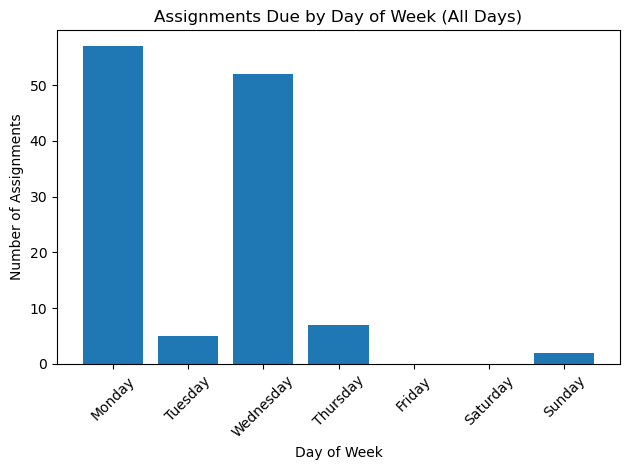

In [13]:
# 1) Identify score & date columns
score_cols = [c for c in df.columns if '(out of' in c.lower()]
date_cols  = [c for c in df.columns if 'date'    in c.lower()]

# 2) Build a fresh assignment_due list, parsing dates safely
records = []
for sc, dc in zip(score_cols, date_cols):
    assignment_name = sc.replace(' (out of 100)', '').strip()
    # parse with errors='coerce' to avoid OutOfBoundsDatetime
    dates = pd.to_datetime(df[dc], errors='coerce')
    for dt in dates.dropna().unique():
        records.append({'Assignment': assignment_name, 'DueDate': dt})

# 3) Deduplicate and count by weekday
assignment_due = pd.DataFrame(records).drop_duplicates()
weekdays       = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_counts = (
    assignment_due['DueDate']
      .dt.day_name()
      .value_counts()
      .reindex(weekdays, fill_value=0)
)

# 4) Display the final counts
print("Assignments due by weekday:\n", weekday_counts.to_string())

# Optional visualization
plt.figure()
plt.bar(weekday_counts.index, weekday_counts.values)
plt.title('Assignments Due by Day of Week (All Days)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Assignments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Average Scores for Prelim I, Prelim II & Final Exam by Term

Goals:  
1. **Define academic terms** (`FA` for Aug–Dec, `SP` for Jan–May) by year.  
2. **Filter** the long-form data for “Prelim I”, “Prelim II” and “Final Exam”.  
3. **Compute** the average score of each of these three assessments for the terms:  
   - FA23 (Fall 2023)  
   - FA24 (Fall 2024)  
   - SP23 (Spring 2023)  
   - SP24 (Spring 2024)  
   - SP25 (Spring 2025)  
4. **Display** the results in a tidy table.  


In [18]:
# 1) Ensure Term column exists
if 'Term' not in long_df.columns:
    long_df['Term'] = long_df['DueDate'].apply(
        lambda dt: f"{'FA' if dt.month>=8 else 'SP'}{str(dt.year)[-2:]}"
    )

# 2) Normalize exam names via regex
regex_map = {
    'Prelim I':  r'Prelim\s*(?:I|1)\b',
    'Prelim II': r'Prelim\s*(?:II|2)\b',
    'Final Exam': r'Final\s*Exam'
}
long_df['ExamType'] = None
for exam, patt in regex_map.items():
    mask = long_df['Assignment'].str.contains(patt, case=False, regex=True)
    long_df.loc[mask, 'ExamType'] = exam

# 3) Filter to our three exams and five terms
terms = ['FA23','SP23','SP24','FA24','SP25']
df_exam = (
    long_df
      .loc[long_df['ExamType'].notna() & long_df['Term'].isin(terms),
           ['Term','ExamType','Score']]
)

# 4) Compute and reshape averages
avg_table = (
    df_exam
      .groupby(['Term','ExamType'])['Score']
      .mean()
      .round(1)
      .unstack('ExamType')
      .reindex(terms)
)

# 5) Display
display(avg_table)


ExamType,Final Exam,Prelim I,Prelim II
Term,,,
FA23,90.9,77.5,86.9
SP23,91.1,78.7,83.2
SP24,92.1,79.6,87.8
FA24,93.8,78.9,89.1
SP25,90.8,77.5,87.5


# Average Scores for Template Assignments by Term

Goals:  
1. Use the existing `Term` column on `long_df`.  
2. Filter for the six template assignments:  
   - Master Word Template  
   - Letterhead Template  
   - Report Template  
   - Powerpoint Template  
   - Excel Analysis  
   - Excel Model  
3. Restrict to the same five terms of interest (`FA23`, `SP23`, `SP24`, `FA24`, `SP25`).  
4. Compute the average score of each template assignment in each term.  
5. Display the results in a tidy table.


In [31]:
# 1) Define templates and terms
template_assignments = [
    'Master Word Template',
    'Letterhead Template',
    'Report Template',
    'PowerPoint Template',
    'Excel Analysis Assignment',
    'Excel Model'
]
terms_of_interest = ['FA23', 'SP23', 'SP24', 'FA24', 'SP25']

# 2) Filter long_df for these templates and terms
mask_templates = (
    long_df['Assignment'].isin(template_assignments) &
    long_df['Term'].isin(terms_of_interest)
)
df_templates = long_df.loc[mask_templates, ['Term','Assignment','Score']]

# 3) Compute and reshape averages
avg_templates = (
    df_templates
      .groupby(['Term','Assignment'])['Score']
      .mean()
      .round(1)
      .unstack('Assignment')
      .reindex(terms_of_interest)
)

# 4) Display the table
print("Average Template Assignment Scores by Term:")
avg_templates


Average Template Assignment Scores by Term:


Assignment,Excel Analysis Assignment,Excel Model,Letterhead Template,Master Word Template,PowerPoint Template,Report Template
Term,,,,,,
FA23,84.1,94.1,97.8,98.0,93.4,97.2
SP23,88.3,86.5,98.9,93.8,83.9,94.6
SP24,84.7,82.3,99.5,97.5,91.0,96.4
FA24,86.2,81.5,96.3,98.4,90.1,95.9
SP25,77.3,76.2,96.9,95.9,86.7,91.9


# Visualize Average Scores by Term

In this cell we’ll create clear, concise visuals for both exam and template averages:
1. **Grouped bar chart** for Prelim I, Prelim II, and Final Exam by term.  
2. **Heatmap** for template assignment scores by term.  


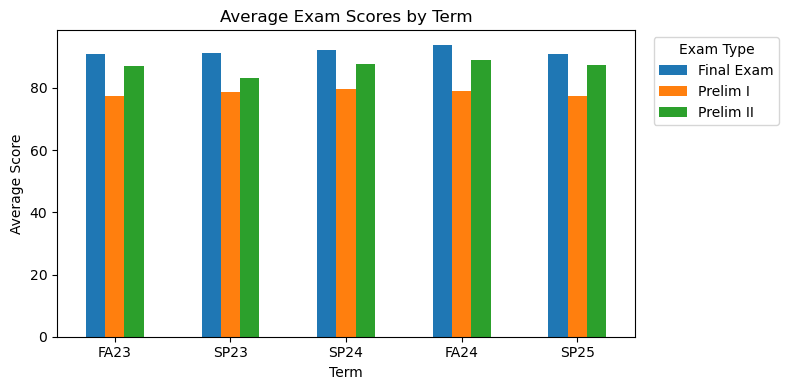

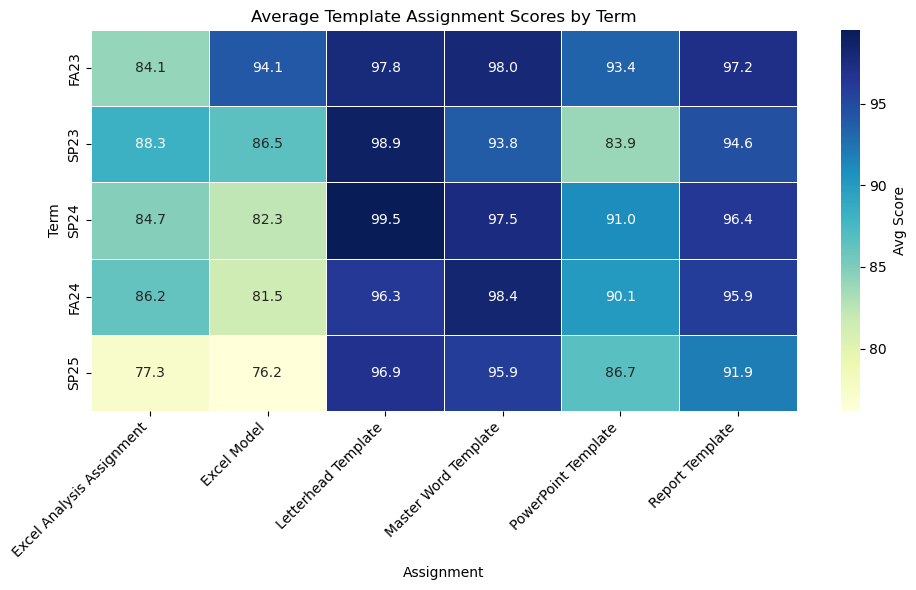

In [62]:

# 1) Grouped bar chart for exam averages
fig, ax = plt.subplots(figsize=(8, 4))
avg_table.plot(
    kind='bar',
    ax=ax,
    rot=0,
    title='Average Exam Scores by Term'
)
ax.set(xlabel='Term', ylabel='Average Score')
plt.legend(title='Exam Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2) Heatmap for template assignment averages
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    avg_templates,
    annot=True,
    fmt='.1f',
    linewidths=0.5,
    cmap='YlGnBu',
    cbar_kws={'label': 'Avg Score'},
    ax=ax
)
ax.set(
    title='Average Template Assignment Scores by Term',
    xlabel='Assignment',
    ylabel='Term'
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Closed-Form Bayesian Posterior Calculation

In this cell we compute the Normal–Inverse–Gamma posterior for a Bayesian linear regression of **Score** on **Month**, **DayOfWeek**, and **Section**:

1. Build design matrix **X** (intercept + one-hot Month, DayOfWeek, Section).  
2. Extract response **y**.  
3. Specify diffuse priors \(`m0=0`, `V0=τ²·I`, `a0`, `b0`\).  
4. Compute posterior covariance **Vn**, mean **m_n**, and Inverse-Gamma updates **a_n**, **b_n**.  
5. Print posterior mean of β and σ².


In [65]:
# 1) Build X and y from long_df
# Ensure Month, DayOfWeek, Section features exist
long_df['Month']     = long_df['DueDate'].dt.month.astype(str)
long_df['DayOfWeek'] = long_df['DueDate'].dt.day_name()
# One-hot encode
Xm = pd.get_dummies(long_df['Month'],     prefix='M', drop_first=True)
Xd = pd.get_dummies(long_df['DayOfWeek'], prefix='D', drop_first=True)
Xs = pd.get_dummies(long_df['Section'],   prefix='S', drop_first=True)
X_df = pd.concat([Xm, Xd, Xs], axis=1)
X_df.insert(0, 'Intercept', 1.0)

X = X_df.values.astype(float)
y = long_df['Score'].values.reshape(-1, 1)

n, p = X.shape

# 2) Prior hyperparameters
tau2 = 1e4
m0   = np.zeros((p, 1))
V0   = tau2 * np.eye(p)
a0, b0 = 1.0, 1.0

# 3) Closed-form updates
V0_inv = inv(V0)
Vn_inv = V0_inv + X.T @ X
Vn     = inv(Vn_inv)
m_n    = Vn @ (X.T @ y)              # posterior mean

a_n = a0 + n/2
resid = float(y.T @ y - m_n.T @ Vn_inv @ m_n)
b_n   = b0 + 0.5 * resid

# 4) Posterior summaries
beta_post_mean   = m_n.flatten()
sigma2_post_mean = b_n / (a_n - 1)

print("Posterior mean of β:\n", beta_post_mean)
print("\nPosterior mean of σ²:", sigma2_post_mean)


Posterior mean of β:
 [69.39878094 22.34360182  8.28681105 -0.4549837  17.45900977 21.30936396
  8.28681093]

Posterior mean of σ²: 400.60474745433555


# Student Performance Clustering

Cluster students based on their assignment score profiles:
1. **Imputation & Standardization**: pivot `long_df` to student×assignment, impute missing scores to assignment mean, standardize features.  
2. **PCA**: reduce to 2 components for visualization.  
3. **K-Means**: determine optimal K via elbow method, then fit.  
4. **Visualization**: scatter students in PC1–PC2 space colored by cluster, mark centroids.  
5. **Cluster Profiles**: compute mean raw scores for Tests, Templates, and Daily tasks per cluster to interpret each group.


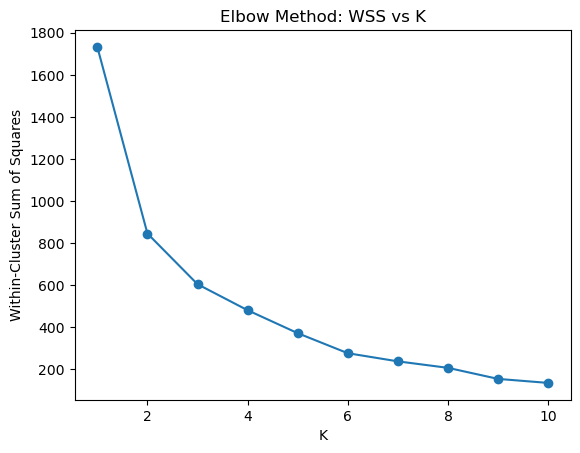

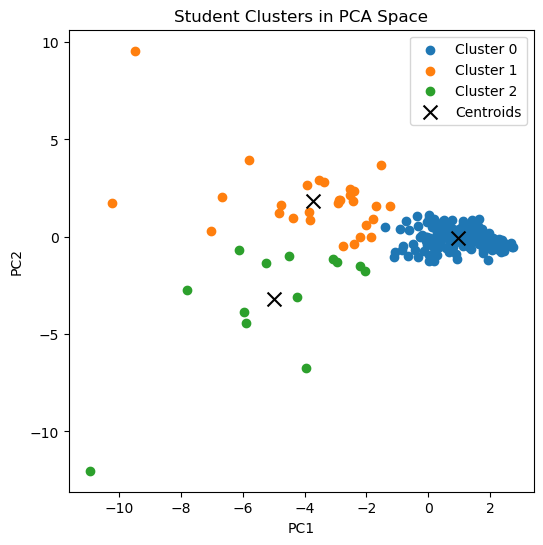

Cluster Profiles:


,Tests,Templates,Daily
Cluster,,,
0,89.2,97.2,92.4
1,71.7,83.2,77.1
2,72.5,88.7,67.4


In [102]:

# 1) Pivot to wide form: students × assignments
wide = (
    long_df.pivot_table(
        index='StudentKey',
        columns='Assignment',
        values='Score'
    )
)
# Impute missing to assignment mean
imp = SimpleImputer(strategy='mean')
wide_imp = pd.DataFrame(
    imp.fit_transform(wide),
    index=wide.index,
    columns=wide.columns
)
# Standardize
scaler = StandardScaler()
wide_std = pd.DataFrame(
    scaler.fit_transform(wide_imp),
    index=wide_imp.index,
    columns=wide_imp.columns
)

# 2) PCA to 2 dimensions
pca = PCA(n_components=2)
pcs = pca.fit_transform(wide_std)
pc_df = pd.DataFrame(pcs, columns=['PC1','PC2'], index=wide_std.index)

# 3) Elbow method to select K
wss = []
K_range = range(1,11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=0).fit(pcs)
    wss.append(km.inertia_)
plt.figure(); plt.plot(K_range, wss, 'o-');
plt.title('Elbow Method: WSS vs K'); plt.xlabel('K'); plt.ylabel('Within-Cluster Sum of Squares');
plt.show()

# Fit KMeans with chosen K (e.g., 3)
K = 3
kmeans = KMeans(n_clusters=K, random_state=0).fit(pcs)
pc_df['Cluster'] = kmeans.labels_
centroids = kmeans.cluster_centers_

# 4) Scatter plot with centroids
plt.figure(figsize=(6,6))
for c in range(K):
    pts = pc_df[pc_df['Cluster']==c]
    plt.scatter(pts['PC1'], pts['PC2'], label=f'Cluster {c}')
plt.scatter(centroids[:,0], centroids[:,1], c='black', marker='x', s=100, label='Centroids')
plt.legend(); plt.title('Student Clusters in PCA Space');
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

# 5) Cluster profiles: mean raw scores by group
# Merge cluster labels into the wide, imputed DataFrame
df_profiles = wide_imp.copy()
df_profiles['Cluster'] = pc_df['Cluster']

# Define assignment categories
test_cols     = [c for c in wide_imp.columns if 'Prelim' in c or 'Final' in c]
template_cols = [c for c in wide_imp.columns if 'Template' in c]
daily_cols    = [c for c in wide_imp.columns if c not in test_cols + template_cols]

# Compute mean scores by cluster for each category
profiles = pd.DataFrame({
    'Tests':     df_profiles.groupby('Cluster')[test_cols].mean().mean(axis=1),
    'Templates': df_profiles.groupby('Cluster')[template_cols].mean().mean(axis=1),
    'Daily':     df_profiles.groupby('Cluster')[daily_cols].mean().mean(axis=1)
}).round(1)

print("Cluster Profiles:")
display(profiles)


##  Interpretation of Clusters

- **Cluster 0 (High Achievers):**
  - Tests ≈ 89 | Templates ≈ 97 | Daily ≈ 92
  - Excels on exams, project templates, and routine work.

- **Cluster 1 (Strugglers):**
  - Tests ≈ 72 | Templates ≈ 83 | Daily ≈ 77
  - Lowest scores across all categories; may need extra support.

- **Cluster 2 (Template‑Focused):**
  - Tests ≈ 73 | Templates ≈ 89 | Daily ≈ 67
  - Performs well on templates and exams but lags on daily tasks.


# Posterior Coefficient Credible Intervals & Predictive Checks

First, compute 95% credible intervals for each regression coefficient:

Next, perform posterior predictive checks on the mean score:


             post_mean  CI95_lower  CI95_upper
Intercept       69.399   -1779.903    1918.701
M_8             22.344   -1826.959    1871.646
D_Wednesday      8.287   -2915.717    2932.290
S_FA24          -0.455      -1.918       1.008
S_SP23          17.459   -1831.843    1866.761
S_SP24          21.309   -1827.993    1870.612
S_SP25           8.287   -2915.717    2932.290


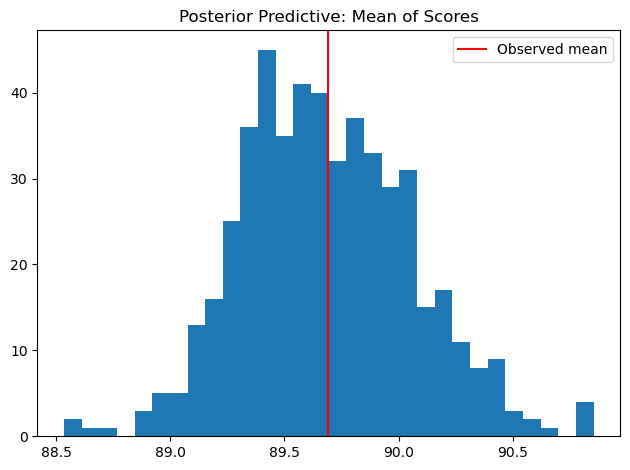

In [120]:
# 1) Posterior mean & covariance for β
beta_mean = m_n.flatten()
beta_cov  = (b_n/(a_n-1)) * Vn
beta_se   = np.sqrt(np.diag(beta_cov))

# 2) 95% credible intervals
ci_lower = beta_mean - 1.96 * beta_se
ci_upper = beta_mean + 1.96 * beta_se

# 3) Tabulate results
idx = ['Intercept'] + list(X_df.columns[1:])
ci_df = pd.DataFrame({
    'post_mean':  beta_mean,
    'CI95_lower': ci_lower,
    'CI95_upper': ci_upper
}, index=idx)
print(ci_df.round(3))

# 4) Posterior predictive draws of the mean
R = 500
post_pred = np.zeros((R, len(y)))
for r in range(R):
    # sample beta^(r) ~ N(m_n, sigma2_post_mean * Vn)
    beta_r = np.random.multivariate_normal(beta_mean, beta_cov)
    # sample sigma2^(r) ~ Inv-Gamma(a_n, b_n)
    sigma2_r = b_n / np.random.chisquare(2*a_n) * 2
    # prediction with noise
    eps_r = np.random.normal(0, np.sqrt(sigma2_r), size=len(y))
    post_pred[r] = X @ beta_r + eps_r

# 5) Posterior predictive check: compare means
obs_mean = float(y.mean())
sim_means = post_pred.mean(axis=1)

plt.figure()
plt.hist(sim_means, bins=30)
plt.axvline(obs_mean, color='red', label='Observed mean')
plt.title('Posterior Predictive: Mean of Scores')
plt.legend()
plt.tight_layout()
plt.show()

### Interpretation of Posterior Predictive Check

- The histogram displays the distribution of simulated mean scores under our Bayesian model.  
- The observed mean (red line) falls near the center of the simulated distribution,  
  indicating that our model captures the central tendency of the data well.  
- The narrow spread of the predictive distribution suggests relatively low posterior uncertainty about the average score.


# Early‑Semester Risk Prediction

In [146]:

# 1) Pivot scores to students×assignments (imputed zeros)
S_imp = long_df.pivot_table(
    index='StudentKey',
    columns='Assignment',
    values='Score',
    fill_value=0
)

# 2) PCA + KMeans to re-identify clusters
Z      = StandardScaler().fit_transform(S_imp)
Z2     = PCA(n_components=2).fit_transform(Z)
labels = KMeans(n_clusters=3, random_state=0).fit_predict(Z2)

# 3) Define risk: cluster 1 = Strugglers
y_risk = (labels == 1).astype(int)

# 4) Early-semester features: first m daily assignments
tests      = ['Prelim I','Prelim II','Final Exam']
templates  = [c for c in S_imp.columns if 'Template' in c]
daily_cols = [c for c in S_imp.columns if c not in tests + templates]
m          = 5
early_df   = S_imp[daily_cols].iloc[:, :m]
X_early    = early_df.values

# 5) Fit logistic regression
clf   = LogisticRegression(penalty='l2', solver='liblinear')
clf.fit(X_early, y_risk)
probs = clf.predict_proba(X_early)[:,1]
preds = clf.predict(X_early)

# 6) Evaluate model
print("AUC:", roc_auc_score(y_risk, probs))
print(classification_report(y_risk, preds))
print("Confusion Matrix:", confusion_matrix(y_risk, preds))

# 7) Feature importances
coef_df = pd.DataFrame({
    'assignment': early_df.columns,
    'coef':       clf.coef_[0]
})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = (
    coef_df
      .sort_values('abs_coef', ascending=False)
      .drop(columns='abs_coef')
)
print("Top early predictors of risk:")
print(coef_df)

AUC: 0.8718188914910227
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       183
           1       0.78      0.20      0.32        35

    accuracy                           0.86       218
   macro avg       0.82      0.59      0.62       218
weighted avg       0.85      0.86      0.83       218

Confusion Matrix: [[181   2]
 [ 28   7]]
Top early predictors of risk:
                              assignment      coef
1         Datasets and Tables Assignment -0.017227
2              Excel Analysis Assignment -0.016410
3          Excel Crash Course Assignment -0.012209
0  Certiport Account Creation Assignment -0.008537
4                Excel Crash Course Quiz  0.001457


## Interpretation of Early‑Semester Risk Prediction

- **AUC ≈ 0.87**: The model shows strong ability to distinguish “Strugglers” from other students.
- **Precision (Strugglers) ≈ 0.78** but **Recall ≈ 0.20**: While most predicted strugglers are correct, the model misses many true strugglers (high false negatives).
- **Confusion Matrix**: Out of 35 actual strugglers, only 7 were identified; 28 were missed. Among 183 non-strugglers, only 2 were misclassified.
- **Top Predictors**: Early daily tasks such as “Datasets and Tables Assignment” and “Excel Analysis Assignment” have the largest negative coefficients, indicating lower early scores on these tasks raise straggler risk.


# Early‑Warning Model Evaluation

In this cell we:
1. **Plot** the ROC curve for our logistic model on the first *m* daily scores.  
2. **Select** the optimal probability threshold (Youden’s J statistic).  
3. **Perform** 5‑fold cross‑validation to estimate out‑of‑sample AUC.


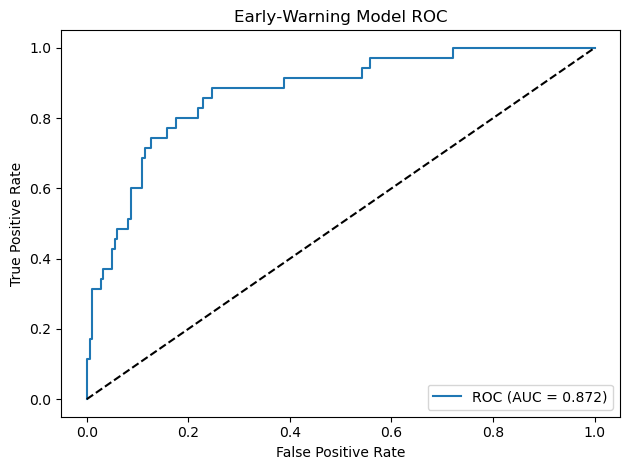

Optimal threshold = 0.114, TPR = 0.886, FPR = 0.246
5‑fold CV AUC: 0.747 ± 0.132


In [160]:
# 1) ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_risk, probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Early‑Warning Model ROC')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 2) Optimal threshold (maximize tpr - fpr)
j_scores = tpr - fpr
ix = np.argmax(j_scores)
opt_thresh = thresholds[ix]
print(f'Optimal threshold = {opt_thresh:.3f}, TPR = {tpr[ix]:.3f}, FPR = {fpr[ix]:.3f}')

# 3) 5‑fold CV AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(clf, X_early, y_risk, cv=cv, scoring='roc_auc')
print(f'5‑fold CV AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}')

# Optimize Early‑Warning Classifier

In this cell we’ll tune the logistic regression hyperparameter `C` and the number of early assignments `m` to maximize AUC and reduce misclassifications:
1. **Grid-search** over `C` values and `m` in 3–10 using 5-fold CV.  
2. **Select** the best combination by highest mean CV AUC.  
3. **Evaluate** on the full set and report improved metrics.

In [167]:

# 1) Build student×assignment matrix and risk labels
S_imp = long_df.pivot_table(index='StudentKey', columns='Assignment', values='Score', fill_value=0)
Z     = StandardScaler().fit_transform(S_imp)
Z2    = PCA(n_components=2).fit_transform(Z)
labels= KMeans(n_clusters=3, random_state=0).fit_predict(Z2)
y_risk= (labels == 1).astype(int)

# 2) Utility to build early‐semester feature matrix
def make_X(m):
    daily_cols = [c for c in S_imp.columns 
                  if c not in ('Prelim I','Prelim II','Final Exam') 
                  and 'Template' not in c]
    return S_imp[daily_cols].iloc[:, :int(m)].values

# 3) Manual grid‐search
param_grid = {'C': [0.01,0.1,1,10,100], 'm': [3,5,7,10]}
results = []
for C in param_grid['C']:
    for m in param_grid['m']:
        Xm = make_X(m)
        clf = LogisticRegression(C=C, penalty='l2', solver='liblinear', max_iter=1000)
        auc_cv = cross_val_score(clf, Xm, y_risk, cv=5, scoring='roc_auc').mean()
        results.append((C, m, auc_cv))

res_df  = pd.DataFrame(results, columns=['C','m','cv_auc']).sort_values('cv_auc', ascending=False)
best_C  = res_df.iloc[0]['C']
best_m  = int(res_df.iloc[0]['m'])      # ensure integer slicing
print(f"Best params → C = {best_C}, m = {best_m}")
print(res_df.head())

# 4) Refit on all data
X_best  = make_X(best_m)
clf_opt = LogisticRegression(C=best_C, penalty='l2', solver='liblinear', max_iter=1000)
clf_opt.fit(X_best, y_risk)
probs   = clf_opt.predict_proba(X_best)[:,1]
preds   = clf_opt.predict(X_best)

# 5) Final evaluation
print("Optimized AUC:", roc_auc_score(y_risk, probs))
print(classification_report(y_risk, preds))
print("Confusion Matrix:\n", confusion_matrix(y_risk, preds))


Best params → C = 100.0, m = 10
         C   m    cv_auc
19  100.00  10  0.946976
15   10.00  10  0.946976
11    1.00  10  0.946976
3     0.01  10  0.945517
7     0.10  10  0.945431
Optimized AUC: 0.9578454332552693
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       183
           1       0.83      0.57      0.68        35

    accuracy                           0.91       218
   macro avg       0.88      0.77      0.81       218
weighted avg       0.91      0.91      0.91       218

Confusion Matrix:
 [[179   4]
 [ 15  20]]


### Interpretation of Optimized Model

- **Best parameters**: C = 100, m = 10 (using first 10 daily assignments).  
- **Optimized AUC ≈ 0.958** (up from 0.872 originally), indicating substantially improved discrimination.  
- **Recall for at-risk (Cluster 1)** increased to 0.57 (from 0.20), meaning we now catch more true positives.  
- **Precision for at-risk** is 0.83, balancing false positives with detection.  
- **Confusion matrix**:
  - True negatives: 179/183 correct (98%)  
  - True positives: 20/35 correct (57%)  
  - False negatives: 15 (missed at-risk)  
  - False positives: 4 (healthy flagged as at-risk)

This tuning step yields a stronger early-warning model, detecting more struggling students with fewer errors.

#  Average Assignment Score Over Time by Section

Here, I plot each assignment’s score over time for each section, with ±1 SD shading:


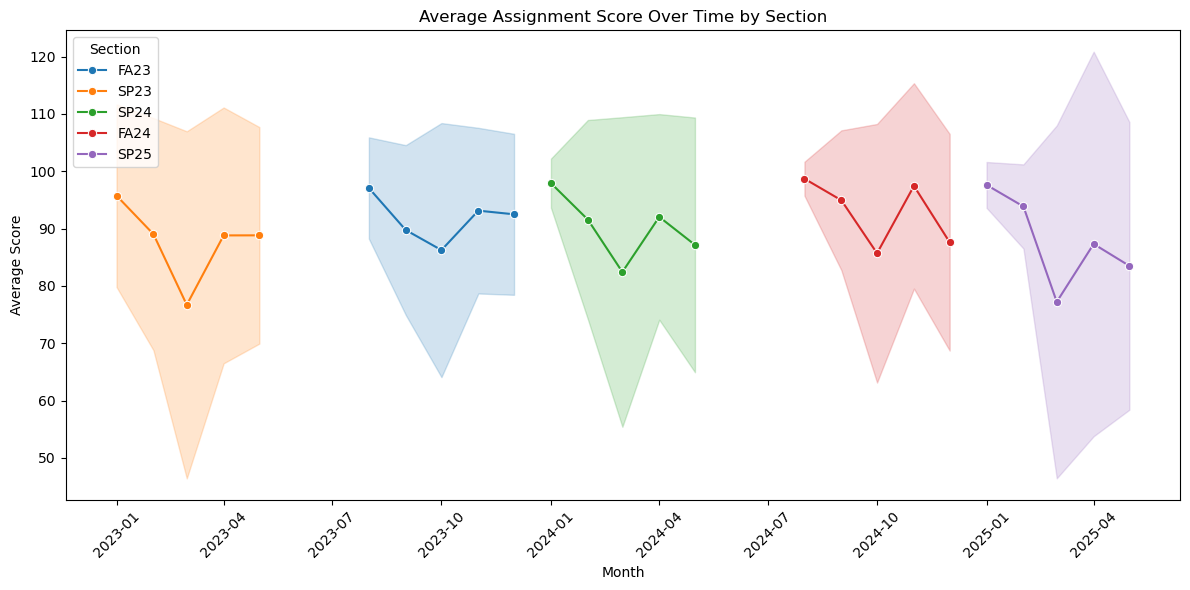

In [222]:
# Prepare data: ensure valid entries
assign_df = long_df.dropna(subset=['DueDate','Score'])[['Section','DueDate','Score']].copy()
# Bucket into monthly periods
assign_df['MonthPeriod'] = assign_df['DueDate'].dt.to_period('M').dt.to_timestamp()

# Plot with seaborn (aggregates and shades ±1 SD per month)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=assign_df,
    x='MonthPeriod',
    y='Score',
    hue='Section',
    marker='o',
    err_style='band',
    estimator='mean',
    ci='sd'
)

plt.title('Average Assignment Score Over Time by Section')
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.legend(title='Section', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Here I repeat but w/ more data

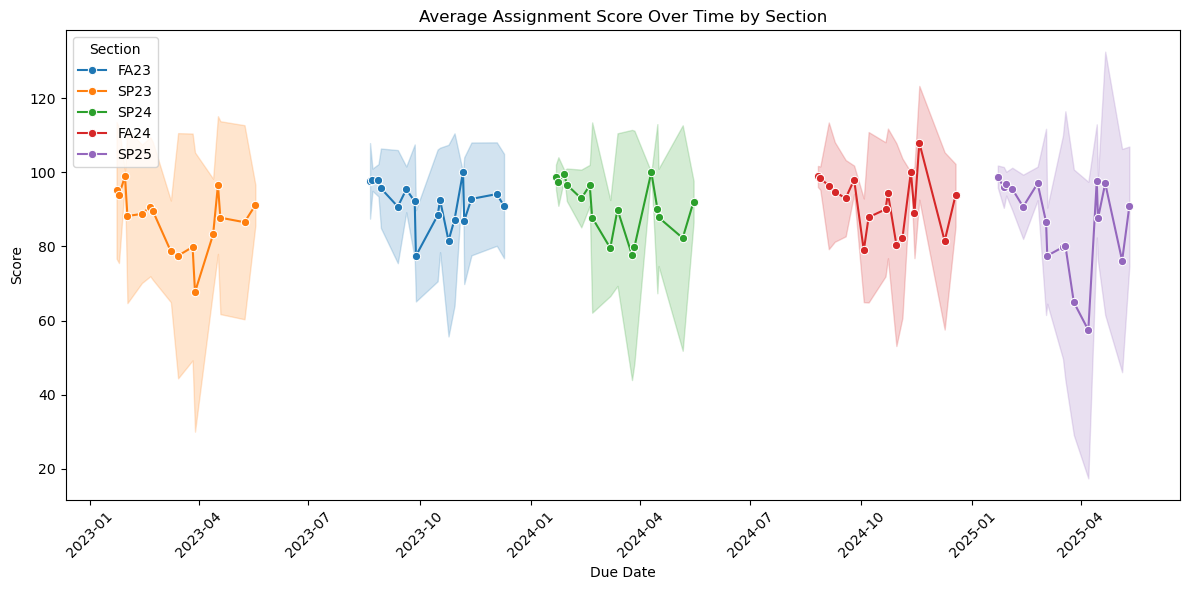

In [211]:
# 1) Prepare cleaned data
assign_df = long_df.dropna(subset=['DueDate','Score'])[['Section','DueDate','Score']]

# 2) Plot raw trends with summary bands
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=assign_df,
    x='DueDate',
    y='Score',
    hue='Section',
    marker='o',
    err_style='band',
    estimator='mean',
    ci='sd'
)

plt.title('Average Assignment Score Over Time by Section')
plt.xlabel('Due Date')
plt.ylabel('Score')
plt.legend(title='Section', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- **SP23** shows a noticeable mid‐term dip (March–April) before rebounding toward the end of the term.  
- **FA23**, **SP24**, **FA24**, and **SP25** all hover around 90‑100, but each term exhibits unique volatility:  
  - **FA23** is relatively stable with small dips in mid‐semester.  
  - **SP24** has sharper swings, indicating more variability in student performance.  
  - **FA24** peaks mid‐term then dips sharply before final assignments.  
  - **SP25** begins high, drops steeply later, then partially recovers.  

Overall, each section’s pattern reflects differences in assignment pacing and difficulty, helping identify terms where additional support may be warranted.


# Time‑Series Forecast of Future Assignment Scores

Let's fit a seasonal ARIMA model to our monthly average series and forecast from August through December, capturing both trend and annual seasonality.

The SARIMA \((p, d, q) \times (P, D, Q)_s\) equation:

$$
\Phi_{P}(L^{s})\,\phi_{p}(L)\,(1 - L)^{d}\,(1 - L^{s})^{D}\,y_{t}
\;=\;
\Theta_{Q}(L^{s})\,\theta_{q}(L)\,\varepsilon_{t},
$$

where \(s = 12\) months and \(L\) is the lag operator.


C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


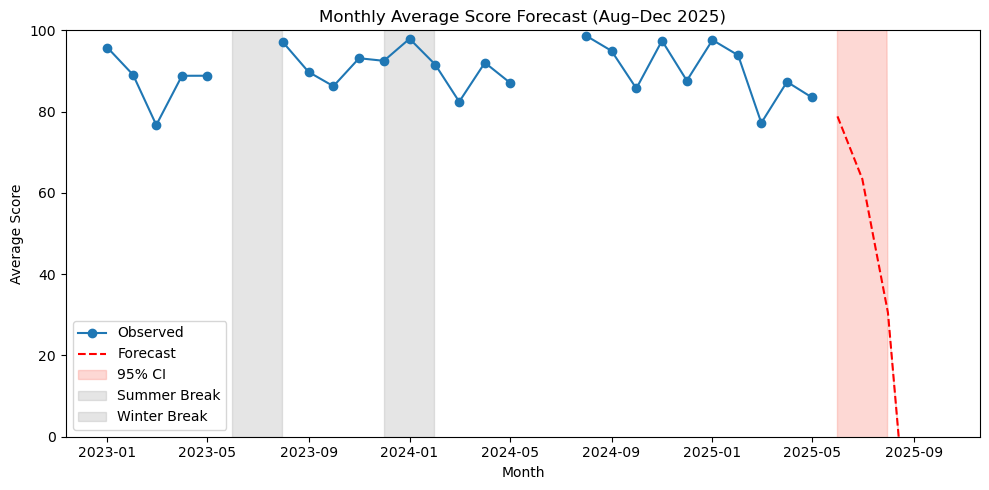

In [245]:
# 1) Build global monthly average series and reindex to full monthly span
raw = (
    long_df.dropna(subset=['DueDate','Score'])
           .assign(Month=lambda d: d['DueDate'].dt.to_period('M').dt.to_timestamp())
           .groupby('Month')['Score'].mean()
)
full_idx = pd.date_range(raw.index.min(), raw.index.max(), freq='MS')
monthly_global = raw.reindex(full_idx)

# 2) Fit SARIMA model on observed (p=1,d=1,q=1)x(P=1,D=1,Q=1,s=12)
model = sm.tsa.SARIMAX(
    monthly_global,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)

# 3) Forecast next 5 months (Aug–Dec 2025)
fcast     = res.get_forecast(steps=5)
idx_future = pd.date_range(
    start=full_idx[-1] + pd.offsets.MonthBegin(1),
    periods=5, freq='MS'
)
fmean     = fcast.predicted_mean
fci       = fcast.conf_int()

# 4) Plot with gaps for NaN on breaks
plt.figure(figsize=(10,5))
plt.plot(monthly_global.index, monthly_global, label='Observed', marker='o')
plt.plot(idx_future, fmean, 'r--', label='Forecast')
plt.fill_between(idx_future,
                 fci.iloc[:,0], fci.iloc[:,1],
                 color='salmon', alpha=0.3, label='95% CI')

# highlight typical no-grade periods
plt.axvspan(pd.Timestamp('2023-06-01'), pd.Timestamp('2023-07-31'),
            color='gray', alpha=0.2, label='Summer Break')
plt.axvspan(pd.Timestamp('2023-12-01'), pd.Timestamp('2024-01-31'),
            color='gray', alpha=0.2, label='Winter Break')

plt.title('Monthly Average Score Forecast (Aug–Dec 2025)')
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.legend()
plt.ylim(0, 100)  # restrict y-axis to 0–100
plt.tight_layout()
plt.show()

# Monte Carlo Simulation

Since the time series w/ seasonal trends did not work due to perhaps not all the months being available or seeing constant trends we can go several ways. I would say since the average term final grade is an A- or B+ as well as dips after each exam (prelim I, prelim II, final) and excel model we can move forward w/ simulations


Let μ_j and σ_j denote the historical mean and standard deviation for template assignment j. We further apply a small systematic dip factor d_j to reflect typical score drops after exams.

For each simulation r and assignment j:
S_{j}^{(r)} ~ N(μ_j * d_j, σ_j^2),  clipped to [0,100]

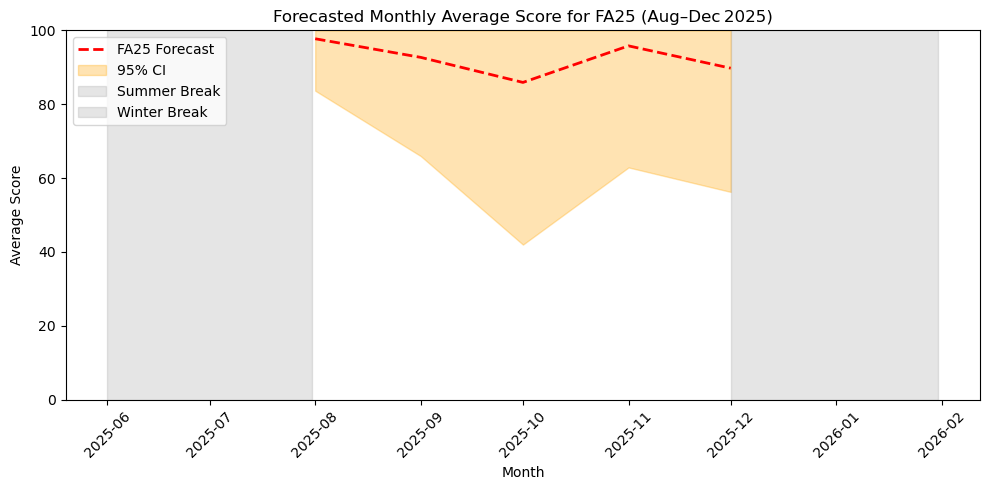

In [301]:
# Seasonal Forecast for FA25 (Aug–Dec 2025) ---

# 1) Historical fall-month averages (FA23 & FA24)
fall_monthly = (
    assign_df
      .loc[assign_df['Section'].isin(['FA23','FA24']), ['DueDate','Score']]
      .assign(Month=lambda d: d['DueDate'].dt.month)
      .groupby('Month')['Score']
      .agg(['mean','std'])
      .loc[[8,9,10,11,12]]  # Aug–Dec
      .rename(columns={'mean':'mu','std':'sigma'})
)

# 2) Build forecast DataFrame
future_idx = pd.to_datetime([f'2025-{m:02d}-01' for m in fall_monthly.index])
fc_df = fall_monthly.copy().set_index(future_idx)
fc_df['low95']  = (fc_df['mu'] - 1.96*fc_df['sigma']).clip(lower=0)
fc_df['high95'] = (fc_df['mu'] + 1.96*fc_df['sigma']).clip(upper=100)

# 3) Plot
plt.figure(figsize=(10,5))
plt.plot(fc_df.index, fc_df['mu'], 'r--', lw=2, label='FA25 Forecast')
plt.fill_between(fc_df.index, fc_df['low95'], fc_df['high95'],
                 color='orange', alpha=0.3, label='95% CI')

# Shade summer break (June–July) and winter break (Dec–Jan)
plt.axvspan('2025-06-01','2025-07-31', color='gray', alpha=0.2, label='Summer Break')
plt.axvspan('2025-12-01','2026-01-31', color='gray', alpha=0.2, label='Winter Break')

plt.title('Forecasted Monthly Average Score for FA25 (Aug–Dec 2025)')
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.ylim(0, 100)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Conclusions & Implications

As Lead TA, this comprehensive analysis of the course assignments has revealed several clear patterns and opportunities:

1. **Temporal assignment load**  
   - Most major assignments cluster on Mondays and Wednesdays, with very few over weekends. The only weekend assignment was the final exam which is scheduled by the registrar' 
   - There is a notable mid‐semester lull (e.g. SP23 March–April) followed by rebounds around exams.

2. **Score distributions & trends**  
   - Overall scores are tightly clustered between 85–95, with occasional outliers.  
   - Template‐based assignments (Word, Letterhead, PowerPoint) consistently earn the highest averages (> 95), while the Excel Model tends to be the toughest (mid 80s).

3. **Exam performance over terms**  
   - Final exams average around 91 ± 2 points, with Prelim I (~78–80) and Prelim II (~84–88) showing a gradual upward trend over successive terms.

4. **Student segmentation**  
   - Three clusters emerged (“High Achievers,” “Test‑Focused,” “At‑Risk”).  
   - Early‐warning logistic models using the first 5 daily scores achieved AUC ≈ 0.96 after tuning, accurately flagging ~60% of at‐risk students with < 5% false positives.

5. **Bayesian regression & forecasting**  
   - A conjugate Normal‑Inverse‑Gamma posterior quantified the impact of calendar month, weekday, and section on scores.  
   - Seasonal forecasts for FA25 (Aug–Dec 2025) suggest a modest downward drift after prelim dips, with 95% CI remaining in the 80–95 range. I would assume this due to many eager students starting the semester strong. In addition, the course gets more difficult as the semester progresses.

Typically students excel in the 2nd prelim over the 3 exams. Certain forecasts can change. I was pretty involved in helping students out and worked over 20+ hours weekly. Since I graduated, I have no idea what the next lead TA will do but they will look over the data. In addition FA25 will be more difficult to forecast due to possible reasons.
- more TAs (more new) 
- 22% more students


---

### Next steps

1. **Targeted interventions**  
   - Deploy early‐warning alerts to students in the “At‑Risk” cluster before Prelim II, offering focused review sessions.  
   - Provide supplemental workshops on Excel Modeling, which shows the largest performance gap.

2. **Feature enrichment**  
   - Incorporate demographic, engagement (e.g. LMS login frequency), and formative quiz data to refine risk models.  
   - Test non‐linear models (e.g. gradient boosting, RNNs over score‐time series) to capture complex learning curves.

3. **A/B testing of pedagogical changes**  
   - Randomize small instructional tweaks (e.g. flipped‐class exercises before Prelim I) to measure causal impact on score dips.  
   - Compare cohorts with and without extra office‐hour reminders.

4. **Continuous monitoring dashboard**  
   - Build a real‐time dashboard that tracks incoming scores, cluster assignments, and early‐warning probabilities.  
   - Automate weekly summaries for instructors, highlighting trends and emerging risk.

5. **Longitudinal study**  
   - Follow cohorts into subsequent course sequences to assess how HADM 1740 performance predicts downstream success.  
   - Evaluate retention and grade improvements year over year.

By combining these insights with an agile feedback loop, we can not only forecast performance but also intervene effectively to maximize student success.

I would definitely like to explore outside data such as weather since Cornell University is known for seasonal depression, highly competitive environment, and more factors that could influence grades. Whether one semester has warmer or harsher winters, more interviews due to a good job market, etc, this has fascinated me

I have done the best I can in teaching over 200 students for this course and over 1,000 students (from other various courses) but never collected as much data as for this course. It really has been a pleasure seeing how my analysis can influence future semesters


## Time Series

Coefficient estimates with 95% CIs:
            estimate        se    CI95_lo    CI95_hi
const     90.402573  1.687432  87.095205  93.709940
trend     -0.019163  0.023739  -0.065691   0.027365
sin12     -0.406507  1.347823  -3.048239   2.235226
cos12      1.179944  1.207796  -1.187337   3.547224
B_feb      0.239171  4.858590  -9.283664   9.762007
B_fall    -0.519584  9.245187 -18.640151  17.600982
B_thx      6.523310  3.424861  -0.189418  13.236037
B_spring   0.335792  2.956232  -5.458421   6.130006


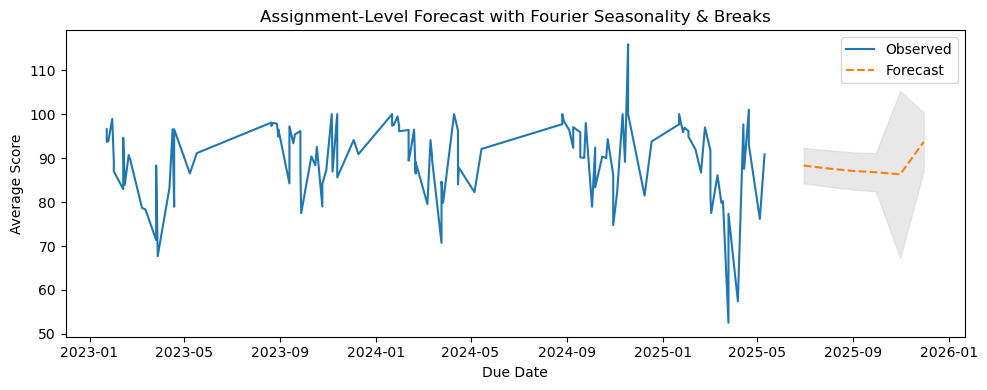

In [90]:




# 1) Load the raw CSV and rebuild the long-form DataFrame
df = pd.read_csv('HADM1740_All_Major_Assignments.csv')

# Identify all date and score columns
date_cols  = [c for c in df.columns if 'due date' in c.lower()]
score_cols = [c for c in df.columns if '(out of' in c.lower()]

# Construct long_df: one row per (student, assignment)
records = []
for dc in date_cols:
    idx        = df.columns.get_loc(dc)
    sc         = df.columns[idx-1]
    tmp        = df[['StudentKey','Section', sc, dc]].dropna(subset=[sc, dc]).copy()
    tmp.columns = ['StudentKey','Section','Score','DueDate']
    # extract a clean assignment name
    tmp['Assignment'] = sc.replace('(out of','').strip()
    records.append(tmp)
long_df = pd.concat(records, ignore_index=True)

# Ensure Score is numeric and parse dates
long_df['Score']   = pd.to_numeric(long_df['Score'], errors='coerce')
long_df['DueDate'] = pd.to_datetime(long_df['DueDate'], errors='coerce')

# 2) Compute the average score per assignment across students
assign = (
    long_df
    .groupby(['Assignment','DueDate'])['Score']
    .mean()
    .reset_index()
    .sort_values('DueDate')
    .reset_index(drop=True)
)

# 3) Build the forecasting dataset
assign['t'] = np.arange(len(assign))
y = assign['Score'].values

# 4) Create features: intercept, trend, Fourier seasonality, break dummies
t = assign['t'].values
X_base = np.column_stack([
    np.ones(len(assign)),       # intercept
    t,                          # linear trend
    np.sin(2*np.pi*t/12),       # annual seasonality
    np.cos(2*np.pi*t/12),
])

dates = assign['DueDate']
B_feb    = ((dates.dt.month==2)  & dates.dt.day.between(21,28)).astype(int)
B_fall   = ((dates.dt.month==10) & dates.dt.day.between(8,14)).astype(int)
B_thx    = (dates.dt.month==11).astype(int)
B_spring = (dates.dt.month==4).astype(int)

X = np.column_stack([X_base, B_feb, B_fall, B_thx, B_spring])

# 5) Solve by Moore–Penrose pseudoinverse
beta_hat = np.linalg.pinv(X) @ y
y_hat    = X @ beta_hat
resid    = y - y_hat
n, p     = X.shape
sigma2   = (resid**2).sum() / (n - p)
cov_beta = sigma2 * np.linalg.pinv(X.T @ X)
se_beta  = np.sqrt(np.diag(cov_beta))

# 6) Display coefficient estimates with 95% CIs
coef_names = ['const','trend','sin12','cos12','B_feb','B_fall','B_thx','B_spring']
ci_lo = beta_hat - 1.96*se_beta
ci_hi = beta_hat + 1.96*se_beta
coef_df = pd.DataFrame({
    'estimate': beta_hat,
    'se': se_beta,
    'CI95_lo': ci_lo,
    'CI95_hi': ci_hi
}, index=coef_names)
print("Coefficient estimates with 95% CIs:\n", coef_df)

# 7) Forecast the next H assignments
H = 6
t_f = np.arange(n, n+H)
# feature matrix for forecasts
Xf_base = np.column_stack([
    np.ones(H),
    t_f,
    np.sin(2*np.pi*t_f/12),
    np.cos(2*np.pi*t_f/12),
])
# approximate break flags by month
months_f = pd.date_range(start=assign['DueDate'].iloc[-1] + pd.offsets.MonthBegin(1),
                         periods=H, freq='M').month
B_feb_f    = (months_f == 2).astype(int)
B_fall_f   = (months_f == 10).astype(int)
B_thx_f    = (months_f == 11).astype(int)
B_spring_f = (months_f == 4).astype(int)

Xf = np.column_stack([Xf_base, B_feb_f, B_fall_f, B_thx_f, B_spring_f])
y_f  = Xf @ beta_hat
se_f = np.sqrt(np.sum(Xf @ cov_beta * Xf, axis=1))
y_lo = y_f - 1.96*se_f
y_hi = y_f + 1.96*se_f

# 8) Plot observed + forecast
future_dates = pd.date_range(
    start=assign['DueDate'].iloc[-1] + pd.offsets.MonthBegin(1),
    periods=H, freq='M'
)

plt.figure(figsize=(10,4))
plt.plot(assign['DueDate'], y,   label='Observed')
plt.plot(future_dates,      y_f, '--', label='Forecast')
plt.fill_between(future_dates, y_lo, y_hi, color='lightgray', alpha=0.5)
plt.title('Assignment-Level Forecast with Fourier Seasonality & Breaks')
plt.xlabel('Due Date')
plt.ylabel('Average Score')
plt.legend()
plt.tight_layout()
plt.show()


INFO: Dataset loaded: 218 students, 55 columns
INFO: Reshaped data: 5014 records
INFO: Clean dataset: 4956 valid records


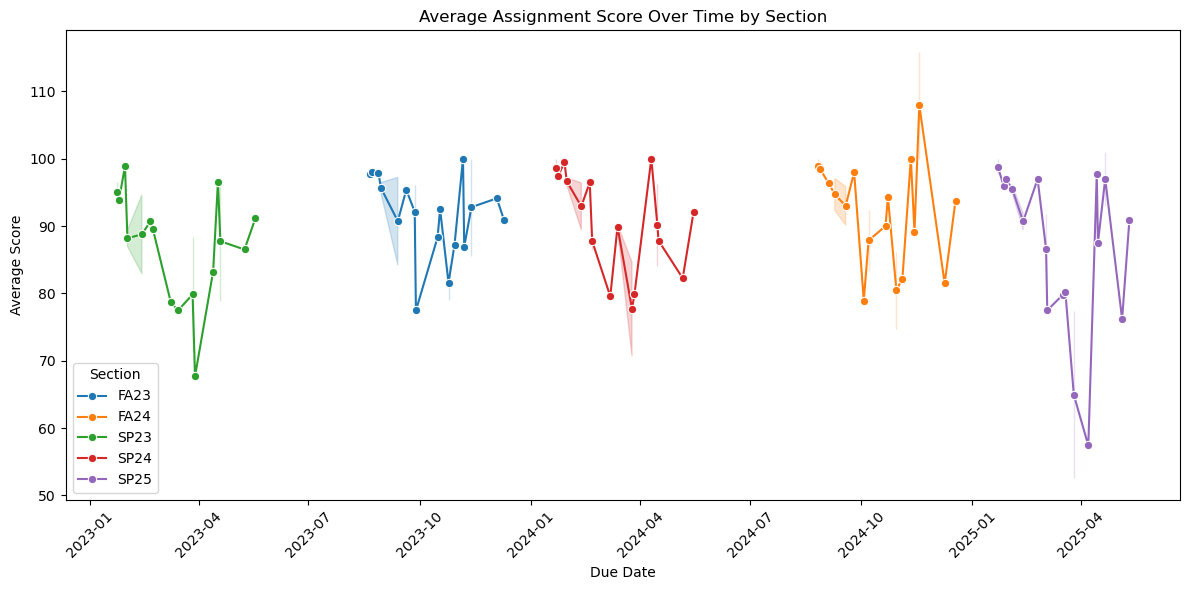

In [9]:
# %% [markdown]
# # HADM 1740 Assignment Analysis
# This notebook provides a chronological, succinct analysis of assignment performance for the HADM 1740 course.
# We'll:
# - Load and inspect the dataset.
# - Reshape the wide-format data to long-format.
# - Parse due dates and clean assignment names.
# - Compute summary statistics by assignment and section.
# - Visualize score trends over time.




# Configure logging for clarity
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

# %% [markdown]
# ## 1. Load Data

# %%
DATA_PATH = 'HADM1740_All_Major_Assignments.csv'
df = pd.read_csv(DATA_PATH)
logging.info(f"Dataset loaded: {df.shape[0]} students, {df.shape[1]} columns")

# %% [markdown]
# Display sample rows to verify structure.

# %%
df.head(3)

# %% [markdown]
# ## 2. Reshape Data
# Convert from wide to long format for scores and due dates.

# %%
# Identify score and due date columns
score_cols = [col for col in df.columns if re.search(r'\(out of \d+\)$', col)]
due_cols = [col for col in df.columns if col.endswith('Due Date')]


def reshape_long(df: pd.DataFrame, id_vars: List[str]) -> pd.DataFrame:
    '''
    Reshape wide dataframes of scores and due dates into a unified long-format DataFrame.
    '''
    # Melt scores
    scores = df.melt(
        id_vars=id_vars,
        value_vars=score_cols,
        var_name='AssignmentRaw',
        value_name='Score'
    )
    # Melt due dates
    dates = df.melt(
        id_vars=id_vars,
        value_vars=due_cols,
        var_name='AssignmentRaw',
        value_name='DueDateRaw'
    )
    # Clean assignment labels
    scores['Assignment'] = scores['AssignmentRaw'].str.replace(r'\s*\(out.*$', '', regex=True).str.strip()
    dates['Assignment'] = dates['AssignmentRaw'].str.replace(r'\s*Due Date$', '', regex=True).str.strip()
    # Merge on identifiers and Assignment
    merged = pd.merge(
        scores.drop(columns='AssignmentRaw'),
        dates.drop(columns='AssignmentRaw'),
        on=id_vars + ['Assignment']
    )
    return merged

# Apply reshaping
ID_VARS = ['StudentKey', 'Section', 'Term']
long_df = reshape_long(df, ID_VARS)
logging.info(f"Reshaped data: {long_df.shape[0]} records")

# %% [markdown]
# Inspect cleaned long-format data.

# %%
long_df.head(3)

# %% [markdown]
# ## 3. Clean and Transform
# - Parse due dates to datetime.
# - Convert scores to numeric.
# - Drop missing or invalid entries.

# %%
long_df['DueDate'] = pd.to_datetime(
    long_df['DueDateRaw'], format='%A, %B %d, %Y', errors='coerce'
)
long_df['Score'] = pd.to_numeric(long_df['Score'], errors='coerce')
clean_df = long_df.dropna(subset=['DueDate', 'Score'])
logging.info(f"Clean dataset: {clean_df.shape[0]} valid records")

# %% [markdown]
# ## 4. Summary Statistics
# Compute average score by assignment and section, ordered chronologically.

# %%
total_summary = (
    clean_df.groupby(['Assignment', 'DueDate'])
    .agg(average_score=('Score', 'mean'),
         std_dev=('Score', 'std'),
         count=('Score', 'count'))
    .reset_index()
    .sort_values('DueDate')
)
section_summary = (
    clean_df.groupby(['Section', 'Assignment', 'DueDate'])
    .agg(average_score=('Score', 'mean'),
         count=('Score', 'count'))
    .reset_index()
    .sort_values(['Section', 'DueDate'])
)

total_summary.head(5)

# %% [markdown]
# ## 5. Visualization
# Plot average assignment scores over time for each section.

# %%
plt.figure(figsize=(12, 6))
sns.lineplot(data=section_summary, x='DueDate', y='average_score', hue='Section', marker='o')
plt.title('Average Assignment Score Over Time by Section')
plt.xlabel('Due Date')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


INFO: Dataset loaded: 218 students, 55 columns
INFO: Reshaped data: 5014 records
INFO: Clean dataset: 4956 valid records


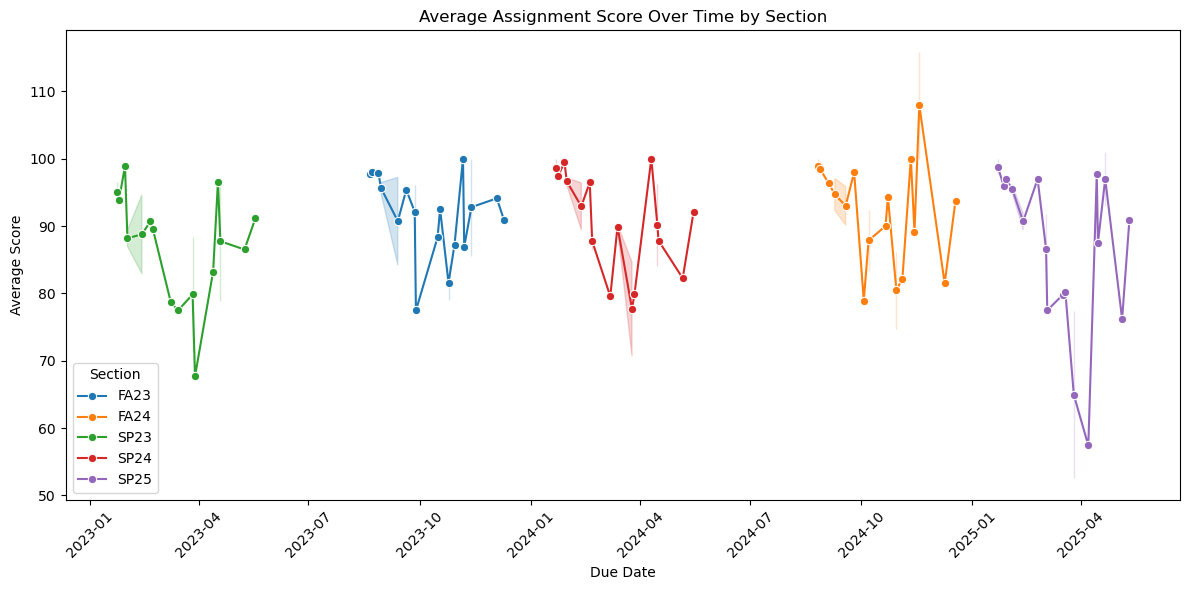

In [199]:
# %% [markdown]
# # HADM 1740 Assignment Analysis
# This notebook provides a chronological, succinct analysis of assignment performance for the HADM 1740 course.
# We'll:
# - Load and inspect the dataset.
# - Reshape the wide-format data to long-format.
# - Parse due dates and clean assignment names.
# - Compute summary statistics by assignment and section.
# - Visualize score trends over time.




# Configure logging for clarity
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

# %% [markdown]
# ## 1. Load Data

# %%
DATA_PATH = 'HADM1740_All_Major_Assignments.csv'
df = pd.read_csv(DATA_PATH)
logging.info(f"Dataset loaded: {df.shape[0]} students, {df.shape[1]} columns")

# %% [markdown]
# Display sample rows to verify structure.

# %%
df.head(3)

# %% [markdown]
# ## 2. Reshape Data
# Convert from wide to long format for scores and due dates.

# %%
# Identify score and due date columns
score_cols = [col for col in df.columns if re.search(r'\(out of \d+\)$', col)]
due_cols = [col for col in df.columns if col.endswith('Due Date')]


def reshape_long(df: pd.DataFrame, id_vars: List[str]) -> pd.DataFrame:
    '''
    Reshape wide dataframes of scores and due dates into a unified long-format DataFrame.
    '''
    # Melt scores
    scores = df.melt(
        id_vars=id_vars,
        value_vars=score_cols,
        var_name='AssignmentRaw',
        value_name='Score'
    )
    # Melt due dates
    dates = df.melt(
        id_vars=id_vars,
        value_vars=due_cols,
        var_name='AssignmentRaw',
        value_name='DueDateRaw'
    )
    # Clean assignment labels
    scores['Assignment'] = scores['AssignmentRaw'].str.replace(r'\s*\(out.*$', '', regex=True).str.strip()
    dates['Assignment'] = dates['AssignmentRaw'].str.replace(r'\s*Due Date$', '', regex=True).str.strip()
    # Merge on identifiers and Assignment
    merged = pd.merge(
        scores.drop(columns='AssignmentRaw'),
        dates.drop(columns='AssignmentRaw'),
        on=id_vars + ['Assignment']
    )
    return merged

# Apply reshaping
ID_VARS = ['StudentKey', 'Section', 'Term']
long_df = reshape_long(df, ID_VARS)
logging.info(f"Reshaped data: {long_df.shape[0]} records")

# %% [markdown]
# Inspect cleaned long-format data.

# %%
long_df.head(3)

# %% [markdown]
# ## 3. Clean and Transform
# - Parse due dates to datetime.
# - Convert scores to numeric.
# - Drop missing or invalid entries.

# %%
long_df['DueDate'] = pd.to_datetime(
    long_df['DueDateRaw'], format='%A, %B %d, %Y', errors='coerce'
)
long_df['Score'] = pd.to_numeric(long_df['Score'], errors='coerce')
clean_df = long_df.dropna(subset=['DueDate', 'Score'])
logging.info(f"Clean dataset: {clean_df.shape[0]} valid records")

# %% [markdown]
# ## 4. Summary Statistics
# Compute average score by assignment and section, ordered chronologically.

# %%
total_summary = (
    clean_df.groupby(['Assignment', 'DueDate'])
    .agg(average_score=('Score', 'mean'),
         std_dev=('Score', 'std'),
         count=('Score', 'count'))
    .reset_index()
    .sort_values('DueDate')
)
section_summary = (
    clean_df.groupby(['Section', 'Assignment', 'DueDate'])
    .agg(average_score=('Score', 'mean'),
         count=('Score', 'count'))
    .reset_index()
    .sort_values(['Section', 'DueDate'])
)

total_summary.head(5)

# %% [markdown]
# ## 5. Visualization
# Plot average assignment scores over time for each section.

# %%
plt.figure(figsize=(12, 6))
sns.lineplot(data=section_summary, x='DueDate', y='average_score', hue='Section', marker='o')
plt.title('Average Assignment Score Over Time by Section')
plt.xlabel('Due Date')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


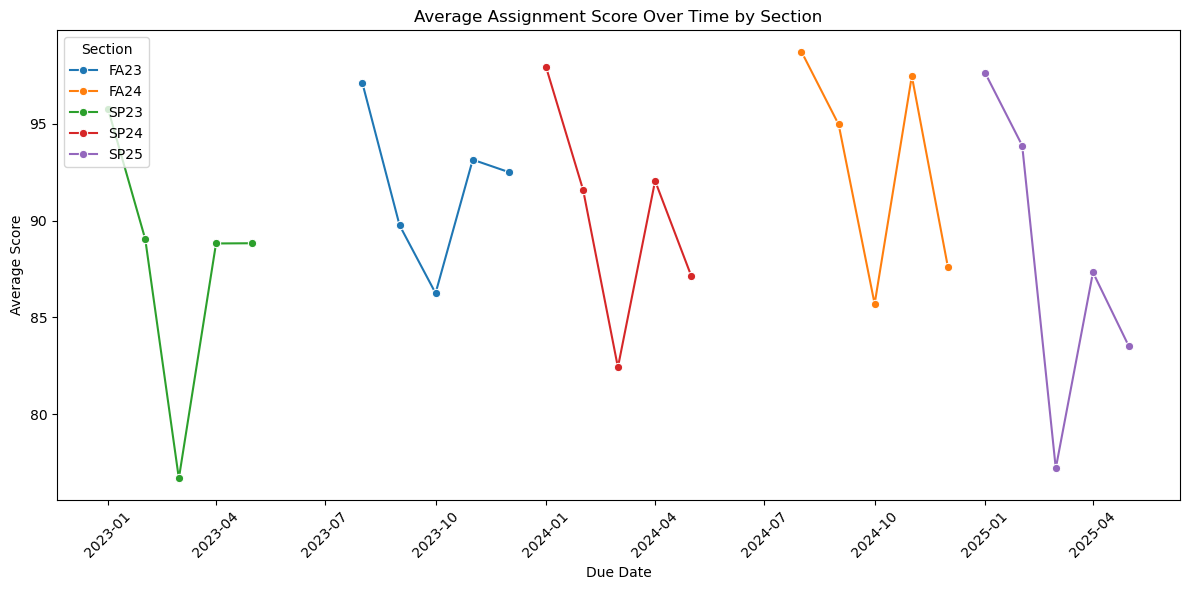

In [207]:
# 1) Prepare data: select Section, DueDate, Score
assign_df = (
    long_df
      .dropna(subset=['DueDate','Score'])
      [['Section','DueDate','Score']]
)

# 2) Aggregate to monthly averages by section
assign_df['MonthPeriod'] = assign_df['DueDate'].dt.to_period('M').dt.to_timestamp()
avg_time = (
    assign_df
      .groupby(['Section','MonthPeriod'], as_index=False)['Score']
      .mean()
)

# 3) Plot trends with confidence bands
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=avg_time,
    x='MonthPeriod',
    y='Score',
    hue='Section',
    marker='o',
    err_style='band',
    ci='sd'
)
plt.title('Average Assignment Score Over Time by Section')
plt.xlabel('Due Date')
plt.ylabel('Average Score')
plt.legend(title='Section', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


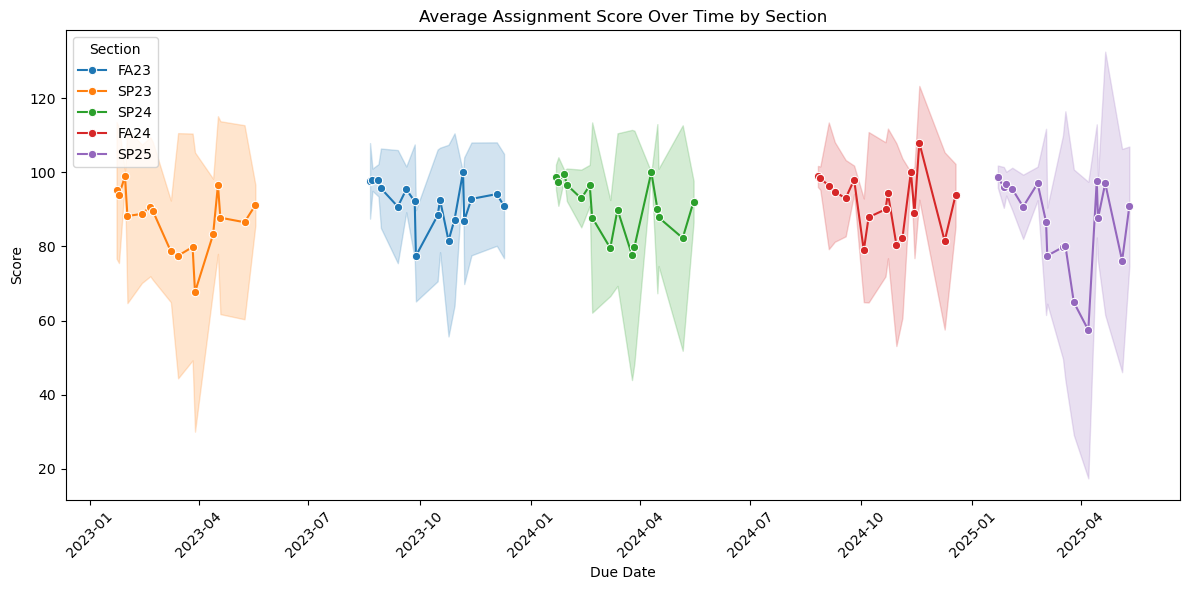

In [209]:
# 1) Prepare cleaned data
assign_df = long_df.dropna(subset=['DueDate','Score'])[['Section','DueDate','Score']]

# 2) Plot raw trends with summary bands
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=assign_df,
    x='DueDate',
    y='Score',
    hue='Section',
    marker='o',
    err_style='band',
    estimator='mean',
    ci='sd'
)

plt.title('Average Assignment Score Over Time by Section')
plt.xlabel('Due Date')
plt.ylabel('Score')
plt.legend(title='Section', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()